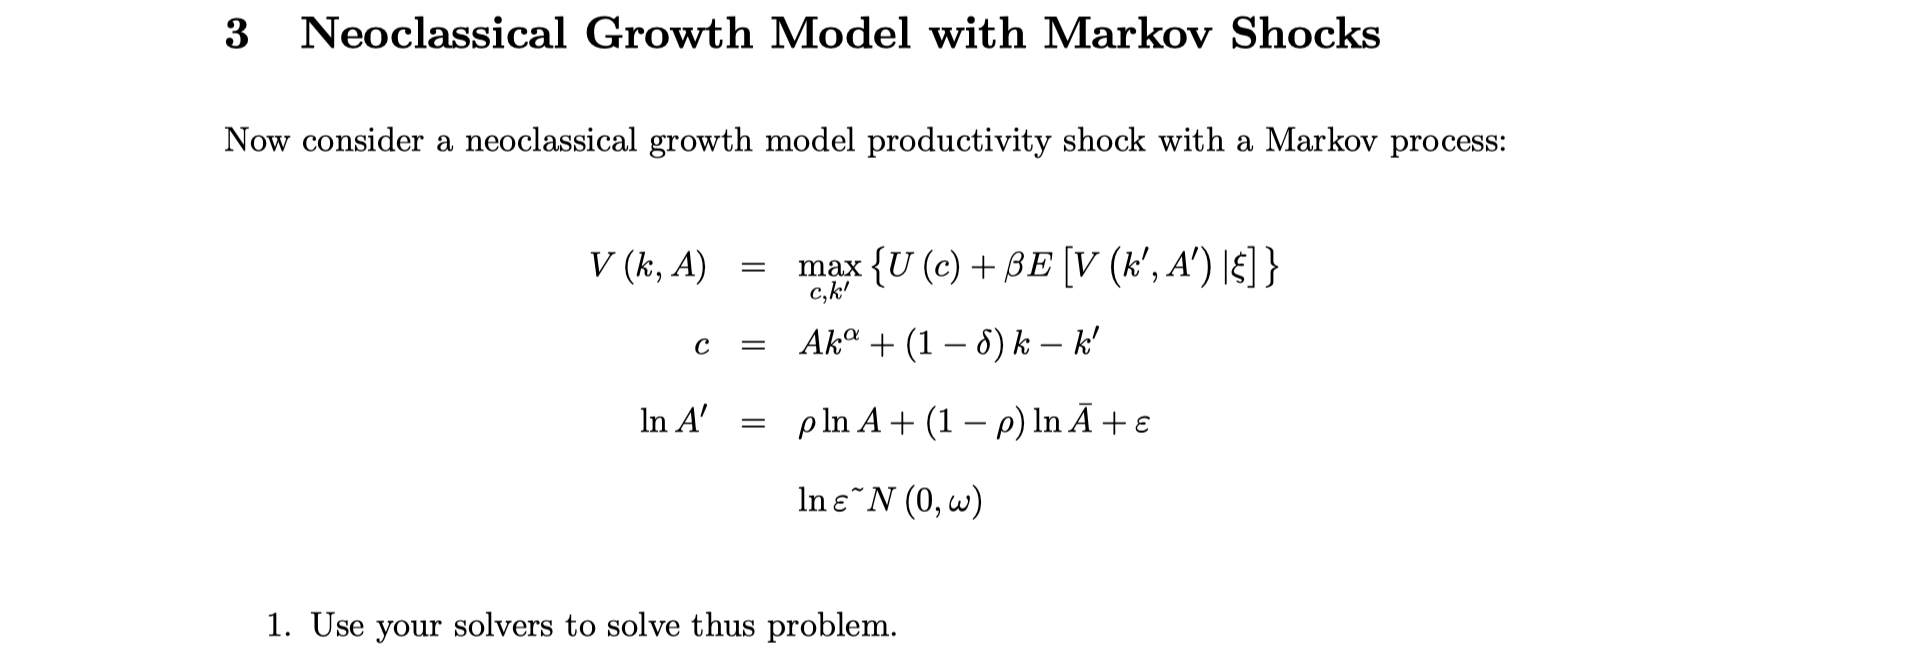

In [9]:
from numpy import array as np_array
from numpy import log as np_log
from joblib import Parallel, delayed
import numpy as np
# from numpy import interp
from scipy.optimize import fsolve, fminbound
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp2d as interp2

np.random.seed(1400)
n_jobs = 10
grid_size = 100
R = 30
R_epsilon = 100
beta,alpha,delta,w,ln_A_bar,rho = 0.9,0.3,0.05,0.05,0.1,0.1


In [10]:
def solver():
    r = lambda x, u, zeta: np_log(u)
    T = lambda x, zeta: zeta * x**alpha + (1-delta)*x

    def g (x, u, zeta):
        return zeta * (x) ** alpha + (1-delta) * x - u 
    
    def zeta_prime_grid(zeta):
        return np.exp(rho* np.log(zeta)+(1-rho)*ln_A_bar+epsilon_sample)

    def value_func_iterate(x_grid, zeta_grid, v0_grid):
        res = np_array(
            Parallel(n_jobs=n_jobs, verbose=0, return_as='list', batch_size=grid_size // n_jobs)
                (delayed(fminbound)
                (func=lambda u, x=x, zeta=zeta: -(r(x, u, zeta) + beta * np_array(interp2(x_grid, zeta_grid, v0_grid)(g(x, u, zeta), zeta_prime_grid(zeta))).mean()), x1=0, x2=T(x,zeta), full_output=True) 
                for zeta in zeta_grid for x in x_grid))
        u_grid, v_grid_updated = np_array(res[:,0]), -np_array(res[:,1])
        u_grid = u_grid.reshape(-1, grid_size)
        v_grid_updated = v_grid_updated.reshape(-1, grid_size)
        return u_grid, v_grid_updated

    epsilon_sample = np.exp(np.random.normal(0, w, R_epsilon))

    k_ss = (np.exp(ln_A_bar+1/(1-rho)) * alpha/(1/beta-1+delta)) ** (1 / (1 - alpha))
    current_z_grid = np.random.normal(np.exp(ln_A_bar+1/(1-rho)),w*2,R) # var?

    current_k_grid = np.linspace(0.000001, 2 * k_ss, grid_size)
    next_k_grid = np.tile(current_k_grid, (R, 1))
    current_y_grid = (np.tile(current_z_grid, (grid_size, 1)).T)*(np.tile(current_k_grid, (R, 1))**alpha)
    current_c_grid = current_y_grid - delta * next_k_grid
    v_grid = np_log(current_c_grid) / (1 - beta)

    max_iter = 200
    tol = 10 ** -3
    for _ in tqdm.tqdm(range(max_iter), ncols=50):
        u_grid, v_grid = value_func_iterate(x_grid=current_k_grid, zeta_grid=current_z_grid, v0_grid=v_grid)
        g_ = (current_y_grid - u_grid + (1-delta)*np.tile(current_k_grid, (R,1)))
        err = np.max(np.abs(g_ - next_k_grid))
        next_k_grid = g_
        if err < tol:
            break
    return k_ss, current_k_grid, current_z_grid, next_k_grid
kss, k, z, k_prime = solver()

  9%|█           | 18/200 [01:01<10:25,  3.44s/it]


In [3]:
# ! pip3 install plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=k_prime.T, x=z, y=k)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

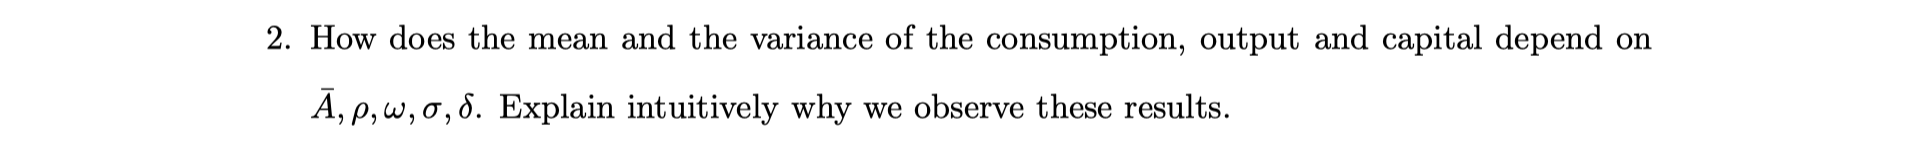

In [4]:
def next_k(init_k, init_z, k_prime, k, z):
    return interp2(k, z, k_prime)(init_k, init_z)[0]

def next_zeta(init_zeta):
    return np.exp(rho*np.log(init_zeta)+(1-rho)*ln_A_bar+np.exp(np.random.normal(0,w)))

def simulate(kss, k_prime, k, z, turn, k_list, z_list): 
    if turn == 0:
        k_list, z_list = np_array(k_list), np_array(z_list)
        y = z_list*(k_list)**alpha
        k_mean, k_var, y_mean, y_var = np.mean(k_list[100:]), np.var(k_list[100:]), np.mean(y[100:]), np.var(y[100:])
        c = y[100:-1] + (1-delta)*k_list[100:-1]-k_list[101:]     
        return (k_mean, k_var, y_mean, y_var, np.mean(c), np.var(c))
    k_list.append(next_k(k_list[-1], z_list[-1], k_prime, k, z))
    z_list.append(next_zeta(z_list[-1]))
    return simulate(kss, k_prime,k,z, turn-1, k_list, z_list)
    
    

In [5]:
grid_size = 50
R=20
for d in [0.01, 0.05, 0.1]:
    delta = d
    kss, k, z, k_prime = solver()
    o = simulate(kss, k_prime, k, z, 1000, [kss/2], [np.exp(ln_A_bar+1/(1-rho))])
    print('delta = ',d, 'k mean & output: ', o[0],o[1], 'y mean & output: ', o[2],o[3],'c mean & output: ', o[4],o[5], '\n')

 10%|█▎          | 21/200 [00:34<04:55,  1.65s/it]


delta =  0.01 k mean & output:  20.615693502456285 0.19632133822252484 y mean & output:  8.33118473832221 0.17425631780075948 c mean & output:  8.125461449244481 0.06454436314923104 



  9%|█           | 18/200 [00:32<05:24,  1.78s/it]


delta =  0.05 k mean & output:  13.756005850190947 0.1772456177136558 y mean & output:  7.38680221533258 0.14368940635596972 c mean & output:  6.699653707876042 0.04005021213109923 



  8%|▉           | 15/200 [00:26<05:22,  1.74s/it]


delta =  0.1 k mean & output:  9.309087600308242 0.06875689404653744 y mean & output:  6.573172020944355 0.11242756137689394 c mean & output:  5.642666275915292 0.041512168753379326 



As depreciation rate increases, average capital, output and consumption decrease.
Since a higher depreciation rate means more capital is lost each period, greater investment is required to maintain capital levels. This reduction in available productive capital leads to lower output and consumption.
As variables decrease, their associated variance also decrease. 

In [6]:

for w_ in [0.01, 0.05, 0.1]:
    w = w_
    kss, k, z, k_prime = solver()
    o = simulate(kss, k_prime, k, z, 1000, [kss/2], [np.exp(ln_A_bar+1/(1-rho))])
    print('w = ',w_, 'k mean & output: ', o[0],o[1], 'y mean & output: ', o[2],o[3],'c mean & output: ', o[4],o[5], '\n')


  7%|▊           | 14/200 [00:23<05:15,  1.70s/it]


w =  0.01 k mean & output:  9.305337364747697 0.002254009999658474 y mean & output:  6.553191668412228 0.00462347445258156 c mean & output:  5.6227136953750785 0.003083625939776833 



  8%|▉           | 15/200 [00:25<05:19,  1.73s/it]


w =  0.05 k mean & output:  9.396079717542518 0.08939730766920527 y mean & output:  6.588046918504952 0.11670434147015057 c mean & output:  5.648690154813162 0.042303172294773615 



  8%|▉           | 15/200 [00:26<05:29,  1.78s/it]


w =  0.1 k mean & output:  9.547715915520094 0.4005190863995179 y mean & output:  6.693498436012057 0.5034363246830924 c mean & output:  5.736828193389299 0.15966888071825674 



As w increases, average of the variables doesn't change, but their variances increase. 
Greater variation of epsilon leads into greater variation of technology, which its variation explains variation of the variables.  

In [7]:
for rho_ in [0.1, 0.3, 0.5]:
    rho = rho_
    kss, k, z, k_prime = solver()
    o = simulate(kss, k_prime, k, z, 1000, [kss/2], [np.exp(ln_A_bar+1/(1-rho))])
    print('rho = ',rho_, 'k mean & output: ', o[0],o[1], 'y mean & output: ', o[2],o[3],'c mean & output: ', o[4],o[5], '\n')

  8%|▉           | 15/200 [00:26<05:25,  1.76s/it]


rho =  0.1 k mean & output:  9.400707680257142 0.3580831136878048 y mean & output:  6.689320435860175 0.5445073114869305 c mean & output:  5.749538626334353 0.23927625675227357 



  8%|▉           | 16/200 [00:27<05:18,  1.73s/it]


rho =  0.3 k mean & output:  14.586849731508345 1.0012265488704855 y mean & output:  10.471299659311711 1.429041928092981 c mean & output:  9.01343616024097 0.7541811917899002 



  9%|█           | 18/200 [00:30<05:10,  1.70s/it]


rho =  0.5 k mean & output:  32.64151436756385 2.160886592802292 y mean & output:  23.24479629723301 9.034382351769972 c mean & output:  19.9811923008061 6.626546031668228 



an increase in $\rho$ would imply a greater persistence of A over time, meaning that the level of A in the next period, is more closely tied to its current level, with less weight given to the long-term mean and the random shock ϵ.
Capital accumulation might become more predictable and stable, as firms expect more consistent productivity levels and thus make more consistent investment decisions, leading into higher capital, output, and consumption averages.

In [8]:
for ln_A in [0.1, 0.3, 0.5]:
    ln_A_bar = ln_A
    kss, k, z, k_prime = solver()
    o = simulate(kss, k_prime, k, z, 1000, [kss/2], [np.exp(ln_A_bar+1/(1-rho))])
    print('ln_A_bar = ',ln_A, 'k mean & output: ', o[0],o[1], 'y mean & output: ', o[2],o[3],'c mean & output: ', o[4],o[5], '\n')


  9%|█           | 18/200 [00:31<05:17,  1.75s/it]


ln_A_bar =  0.1 k mean & output:  33.27909189021839 0.6401643669680869 y mean & output:  23.55815622133207 7.3562642512717895 c mean & output:  20.23776770503282 6.01236605702722 



  9%|█           | 18/200 [00:31<05:17,  1.74s/it]


ln_A_bar =  0.3 k mean & output:  44.36906527414963 3.5488166334336024 y mean & output:  31.832486109092372 15.506343885500552 c mean & output:  27.393442243848266 11.579391733995896 



 10%|█▏          | 19/200 [00:33<05:16,  1.75s/it]


ln_A_bar =  0.5 k mean & output:  59.17932173801664 1.943391551322455 y mean & output:  42.32431779434504 28.22729835796153 c mean & output:  36.399107467621654 23.43215493869666 



As A_bar increases, it enhances the efficiency with which capital is used. This leads to higher output from the same amount of inputs, which in turn boosts consumption and investment possibilities, overall promoting economic variables.